In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
import math

In [2]:
# function 1: load the batch
# return X: contains  the  image  pixel  data
#        Y: contains the one-hot representation of the label for each image
#        y: contains the label for each image
def load_batch(file): 
    with open(file, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    X = batch['data'].transpose() / 255
    
    y = batch['labels']
    
    Y = np.zeros((len(y), 10))
    for idx, val in enumerate(y):
        Y[idx][val] = 1
    
    return X, Y.transpose(), y

In [3]:
train_X, train_Y, train_y = load_batch('Datasets/cifar-10-batches-py/data_batch_1')
validation_X, validation_Y, validation_y = load_batch('Datasets/cifar-10-batches-py/data_batch_2')
test_X, test_Y, test_y = load_batch('Datasets/cifar-10-batches-py/test_batch')
print(train_X)

[[0.23137255 0.60392157 1.         ... 0.27843137 0.98039216 0.24313725]
 [0.16862745 0.49411765 0.99215686 ... 0.23529412 0.99607843 0.23921569]
 [0.19607843 0.41176471 0.99215686 ... 0.29019608 0.82745098 0.23529412]
 ...
 [0.54901961 0.54509804 0.3254902  ... 0.26666667 0.84313725 0.50980392]
 [0.32941176 0.55686275 0.3254902  ... 0.27058824 1.         0.50980392]
 [0.28235294 0.56470588 0.32941176 ... 0.26666667 0.99607843 0.51372549]]


In [4]:
# function 2: initialize model W and b with random gaussian values
# with zero mean and standard deviation of 0.01
def init_model_W_b(W_first, W_second, b_first, b_second):
    zero_mean = 0
    std_dev = 0.01
    np.random.seed(0)
    W = np.random.normal(zero_mean, std_dev, size = (W_first, W_second))
    b = np.random.normal(zero_mean, std_dev, size = (b_first, b_second))
    return W, b

In [5]:
k = 10 # number of lables
d = 3072 # dimentionality of each image 32x32x3 = 3072
model_W, model_b = init_model_W_b(k, d, k, 1)

In [6]:
# evaluate the network
def evaluate_classifier(X, W, b):
    # formula s = WX + b
    s = np.matmul(W, X)
    s = np.add(s, b)
    
    # p = softmax(s), softmax function exp(s) / 1^T exp(s)
    exp = [np.exp(i) for i in s]
    one_trans_exp = np.matmul(np.ones((1, len(exp))), exp)
    softmax = np.divide(exp, one_trans_exp)

    return softmax

In [10]:
train_p = evaluate_classifier(train_X, model_W, model_b)
validation_p = evaluate_classifier(validation_X, model_W, model_b)
test_p = evaluate_classifier(test_X, model_W, model_b)
print("Probability for batch 1: ")
print(train_p)
print(train_p.shape)
print((train_p.transpose())[0].sum())

Probability for batch 1: 
[[0.07385914 0.0503655  0.09030947 ... 0.08553263 0.06986421 0.05830294]
 [0.11457266 0.10772433 0.10998242 ... 0.10455005 0.09323334 0.11112274]
 [0.06975487 0.09487183 0.07052145 ... 0.08198671 0.06009834 0.05606204]
 ...
 [0.11002674 0.11166967 0.11770924 ... 0.11389606 0.12901164 0.11288395]
 [0.08727193 0.0910242  0.09847462 ... 0.09225712 0.11313404 0.09224194]
 [0.06282313 0.04550412 0.07189186 ... 0.06898728 0.05471979 0.05700712]]
(10, 10000)
0.9999999999999999


In [12]:
#Visualizing CIFAR 10
def view(X):
    X = X * 255
    X = X.transpose().reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(len(X)))
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(X[i:i+1][0])

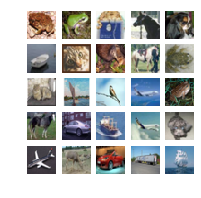

In [13]:
view(train_X)

In [14]:
# computes the cost function for a set of images
def compute_cost(X, Y, W, b, lambda_):
    one_over_data_magnitude = 1 / len(X[0])
    p = evaluate_classifier(X, W, b)
    Y_T_p = np.matmul(Y.transpose(), p)
    l_cross = np.log(Y_T_p) * -1
    l_cross_sum = l_cross.sum() 
    
    W_squared = W ** 2
    W_squared_sum = W_squared.sum()
    
    cost = (one_over_data_magnitude * l_cross_sum) + (lambda_ * W_squared_sum)

    return cost

In [16]:
J = compute_cost(train_X, train_Y, model_W, model_b, 1)
J

23473.386364785674

In [17]:
# computes the accuracy of the network’s
# predictions on a set of data
def compute_accuracy(X, y, W, b):
    p = evaluate_classifier(X, W, b)
    p_trans = p.transpose()
    
    arg_max = []
    for i in p_trans:
        arg_max.append(np.argmax(i))
        
    pred_corr = 0
    for i in range(len(arg_max)):
        if arg_max[i] == y[i]:
            pred_corr += 1
    
    accuracy = pred_corr / len(arg_max)
    
    return accuracy

In [18]:
acc = compute_accuracy(train_X, train_y, model_W, model_b)
acc

0.1006

In [19]:
def compute_gradients(X, Y, P, W, lmbda):
    G_batch = np.subtract(Y, P) * -1
    L_w_r_t_W = 1 / len(Y[0]) * G_batch.dot(X.transpose())
    L_w_r_t_b = 1 / len(Y[0]) * G_batch.dot(np.ones((len(Y[0]), 1)))
    grad_W = L_w_r_t_W + (2 * lmbda * W)
    grad_b = L_w_r_t_b
    
    return grad_W, grad_b

In [21]:
grad_W, grad_b = compute_gradients(train_X, train_Y, p_batch_1, model_W, 1)
print(grad_W.shape)
print(grad_b.shape)

(10, 3072)
(10, 1)


In [40]:
# ComputeGradsNumSlow.m python version
def ComputeGradsNumSlow(X, Y, W, b, lambda_, h):
    no = len(W)
    
    grad_W = np.zeros(W.shape)
    grad_b = np.zeros(no)
    
    for i in range(len(b)):
        b_try = b
        b_try[i] = b_try[i] - h
        c1 = compute_cost(X, Y, W, b_try, lambda_)
        
        b_try = b
        b_try[i] = b_try[i] + h
        c2 = compute_cost(X, Y, W, b_try, lambda_)
        
        grad_b[i] = (c2-c1) / (2*h)
        
    for i in range(len(W)):
        for j in range(len(W[i])):
            W_try = W
            W_try[i][j] = W_try[i][j] - h
            c1 = compute_cost(X, Y, W_try, b, lambda_)

            W_try = W
            W_try[i][j] = W_try[i][j] - h
            c2 = compute_cost(X, Y, W_try, b, lambda_)

            grad_b[i] = (c2-c1) / (2*h)
            
    return grad_b, grad_W

In [41]:
ComputeGradsNumSlow(train_X, train_Y, model_W, model_b, 0, 0.000001)

KeyboardInterrupt: 